In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid
import xroms
from cartopy import config
from glob import glob
from Rossby_deformation.funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
# Opening the turbine coordinates as a xArray DataSet
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [3]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [4]:
# Longitudes and latitudes of the grid
lon = grid.lon_rho
lat = grid.lat_rho

In [5]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files_ref=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files_ref.append(filefolder[0]+file_path)

In [6]:
filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/EXP')

files_exp=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files_exp.append(filefolder[0]+file_path)

In [8]:
R1_ref = extract_R1_all(files_ref)

Text(0.5, 0.98, 'REF Rossby deformation radius 2022-02-02T12:00:00.000000000')

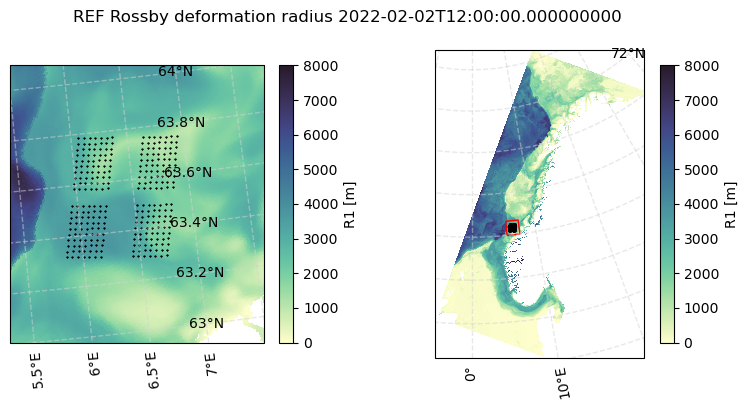

In [18]:
proj = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

ax[0].set_extent([5.5, 7.5, 63, 64])
pll = ax[0].pcolormesh(lon, lat, R1_ref[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=8000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, R1_ref[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [5.5, 7.5, 7.5, 5.5]
area_lat = [63, 63, 64, 64]

ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

for axs in ax:
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    for i in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[i][0], nordvest_C.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 

fig.suptitle(f'REF Rossby deformation radius {R1_ref.ocean_time[0]}')

In [20]:
R1_roll_7 = R1_rolling_mean_all(files_ref)

In [21]:
# Finding eta_rho and xi_rho incides of Nordvest midpoints
# Midpoint coordinates are guessed on by the plot above
j_1, i_1 = find_indices_of_point(grid, 6.75, 63.7)  # Turbine cluster 1. quadrant

j_2, i_2 = find_indices_of_point(grid, 6.25, 63.7)  # Turbine cluster 2. quadrant

j_3, i_3 = find_indices_of_point(grid, 6.1, 63.41)  # Turbine cluster 3. quadrant

j_4, i_4 = find_indices_of_point(grid, 6.6, 63.41)  # Turbine cluster 4. quadrant